In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d
from numba import njit
import h5py as h5
import os

In [5]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [24]:
def get_rough_metallicity(MW_mass, MW_metal_frac, GSE_mass, GSE_metal_frac):
    MW_metal = MW_mass * MW_metal_frac
    GSE_metal = GSE_mass * GSE_metal_frac
    
    return (MW_metal + GSE_metal) / (MW_mass + GSE_mass)

In [58]:
def get_dilution_profile(snap, name):

    fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
    f = h5.File(fname, mode='r')

    pos = f['PartType5/RotatedCoordinates'][:]
    ptype = f['PartType5/PartType'][:]
    mass = f['PartType5/Masses'][:]
    memb = f['PartType5/Membership'][:]
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,2]

    Rmin = 0.
    dR = 0.5

    metallicity = []
    dilution = []
    aveR = []

    while Rmin < 15:
        in_annulus = np.logical_and(R > Rmin, R < Rmin+dR)
        in_annulus = np.logical_and(in_annulus, np.abs(z) < 3)
        gas_in_annulus = np.logical_and(ptype==0, in_annulus)
    
        memb0_key = np.logical_and(gas_in_annulus, memb==0)
        memb1_key = np.logical_and(gas_in_annulus, memb==1)
        memb2_key = np.logical_and(gas_in_annulus, memb==2)
        memb3_key = np.logical_and(gas_in_annulus, memb==3)
    
        mass0 = np.sum(mass[memb0_key])
        mass1 = np.sum(mass[memb1_key])
        mass2 = np.sum(mass[memb2_key])
        mass3 = np.sum(mass[memb3_key])
    
        metal_annulus = get_rough_metallicity((0.3/0.7)*(mass0 + mass1), 10.**(-0.3)*0.0127, mass2+mass3, 10.**(-1.2)*0.0127)
    
        metallicity.append(metal_annulus)
        dilution.append((mass2+mass3) / (mass0 + mass1 + mass2+mass3))
        aveR.append(np.mean(R[gas_in_annulus]))

        # print(np.mean(R[gas_in_annulus]), mass0 + mass1, mass2)
        
        Rmin += dR
    
    metallicity = np.array(metallicity)
    dilution = np.array(dilution)
    aveR = np.array(aveR)
    time = f['Header'].attrs['Time']

    f.close()
    
    return time, aveR, dilution, metallicity

In [59]:
time, aveR, dilution, metallicity = get_dilution_profile(800, 'MW3_MHG0.25_GSE2_MHG0.18_Rcut10-lvl4')

(0.0, 0.2)

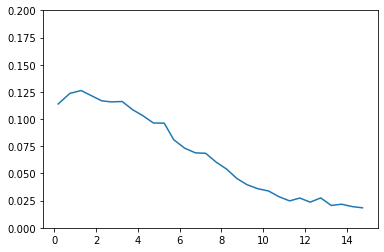

In [60]:
plt.plot(aveR, dilution)
plt.ylim(0, 0.2)

(-0.8, -0.25)

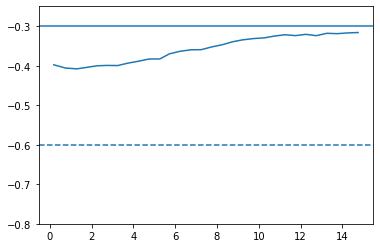

In [61]:
plt.plot(aveR, np.log10(metallicity/0.0127))
plt.axhline(-0.3)
plt.axhline(-0.6, ls='dashed')
plt.ylim(-0.8, -0.25)

In [62]:
dil = np.load(basepath+'anlys/dilution/dil_MW3_MHG0.25_GSE2_MHG0.18_Rcut10-lvl4.npy', allow_pickle=True).item()

In [66]:
dil['aveR'][800]

array([ 0.19182924,  0.75027614,  1.28600756,  1.73036373,  2.27459404,
        2.71759567,  3.25334874,  3.76095904,  4.24281398,  4.74631437,
        5.26427603,  5.71947392,  6.24460961,  6.76019901,  7.24474623,
        7.75443382,  8.24736953,  8.74435643,  9.23286696,  9.75192416,
       10.25773423, 10.73739106, 11.26231659, 11.74866767, 12.2440286 ,
       12.75030551, 13.25381647, 13.75090618, 14.26326074, 14.7489677 ])

In [68]:
dil.keys()

dict_keys(['Time', 'aveR', 'dilution', 'metallicity'])